# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [1]:
import numpy as np


In [2]:

from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
# Inspect the shapes of the datasets

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10) 



(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


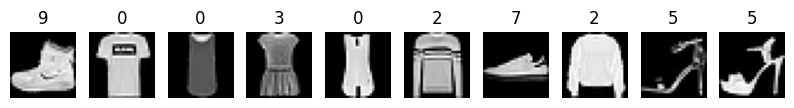

In [4]:
import matplotlib.pyplot as plt
# Verify the data looks as expected

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i +1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
    plt.title(str(y_train[i].argmax()))
plt.show()

    

Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**

The data quality looks good overall, I've chosen grey scale because it will make the edge's gradient more apparent.

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [5]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split


# Create a simple linear regression model
model = Sequential()
model.add(Flatten()) # first flatten the image
model.add(Dense(10, activation='softmax')) # second block: output layer

# You can use `model.add(<layer>)` to add layers to the model

# Compile the model using `model.compile()`
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model with `model.fit()`
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True) 

# Evaluate the model with `model.evaluate()`

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - accuracy: 0.7937 - loss: 0.6144 - val_accuracy: 0.8362 - val_loss: 0.4828
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - accuracy: 0.8411 - loss: 0.4668 - val_accuracy: 0.8428 - val_loss: 0.4518
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.8494 - loss: 0.4391 - val_accuracy: 0.8448 - val_loss: 0.4500
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.8539 - loss: 0.4257 - val_accuracy: 0.8473 - val_loss: 0.4284
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.8572 - loss: 0.4166 - val_accuracy: 0.8548 - val_loss: 0.4162
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - accuracy: 0.8589 - loss: 0.4089 - val_accuracy: 0.8508 - val_loss: 0.4202
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.8610 - loss: 0.4036 - val_accuracy: 0.8587 - val_loss: 0.4119
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.8616 -

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**

Given the fact that this is a flat linear model, no hidden layers, 85% accuracy is pretty impressive. Large loss seems to be accurate. 


# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [8]:
from keras.layers import Conv2D

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Create a simple CNN model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# Train the model

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True) 

# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8565 - loss: 0.4037 - val_accuracy: 0.8858 - val_loss: 0.3175
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8976 - loss: 0.2851 - val_accuracy: 0.8955 - val_loss: 0.2977
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9103 - loss: 0.2470 - val_accuracy: 0.8992 - val_loss: 0.2909
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9219 - loss: 0.2184 - val_accuracy: 0.9000 - val_loss: 0.2806
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9282 - loss: 0.1964 - val_accuracy: 0.8957 - val_loss: 0.2976
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9368 - loss: 0.1762 - val_accuracy: 0.9070 - val_loss: 0.2863
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9424 - loss: 0.1585 - val_accuracy: 0.9007 - val_loss: 0.3091
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9489 - loss: 0.1439 - val_accurac

Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**

The CNN model performed better than the baseline model, with an accuracy of 90% compared to 75% for the baseline model. But the accuracy went up to 95% before coming down to 90%.


# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [16]:
# A. Test Hyperparameters

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')



Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8530 - loss: 0.4115 - val_accuracy: 0.8910 - val_loss: 0.3058
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9028 - loss: 0.2715 - val_accuracy: 0.8970 - val_loss: 0.2766
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9190 - loss: 0.2214 - val_accuracy: 0.9028 - val_loss: 0.2701
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9350 - loss: 0.1807 - val_accuracy: 0.9102 - val_loss: 0.2584
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9451 - loss: 0.1492 - val_accuracy: 0.9110 - val_loss: 0.2847
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9552 - loss: 0.1232 - val_accuracy: 0.8960 - val_loss: 0.3272
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9632 - loss: 0.1027 - val_accuracy: 0.9113 - val_loss: 0.3201
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9687 - loss: 0.0856 - val

In [13]:
# B. Test presence or absence of regularization
from keras.regularizers import l2
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)))
model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10,
batch_size=32, validation_split=0.1, shuffle=True)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8572 - loss: 0.4105 - val_accuracy: 0.8878 - val_loss: 0.3178
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8970 - loss: 0.2935 - val_accuracy: 0.8900 - val_loss: 0.3130
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9091 - loss: 0.2594 - val_accuracy: 0.8968 - val_loss: 0.2900
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9185 - loss: 0.2362 - val_accuracy: 0.9015 - val_loss: 0.2889
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9250 - loss: 0.2172 - val_accuracy: 0.8967 - val_loss: 0.2950
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9322 - loss: 0.2008 - val_accuracy: 0.9032 - val_loss: 0.2930
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9366 - loss: 0.1861 - val_accuracy: 0.9017 - val_loss: 0.3023
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9413 - loss: 0.1745 - val_accurac

In [15]:
#testing 1 layer + L2 regularization

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True) 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')



Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8526 - loss: 0.4398 - val_accuracy: 0.8838 - val_loss: 0.3385
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8979 - loss: 0.3077 - val_accuracy: 0.8948 - val_loss: 0.3166
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9117 - loss: 0.2680 - val_accuracy: 0.9007 - val_loss: 0.2986
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9211 - loss: 0.2413 - val_accuracy: 0.9067 - val_loss: 0.2831
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9304 - loss: 0.2171 - val_accuracy: 0.9083 - val_loss: 0.2834
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9375 - loss: 0.2003 - val_accuracy: 0.9105 - val_loss: 0.2914
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9434 - loss: 0.1868 - val_accuracy: 0.9052 - val_loss: 0.3008
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9483 - loss: 0.1713 - val

In [22]:
from keras.layers import MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')





Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8511 - loss: 0.4215 - val_accuracy: 0.8895 - val_loss: 0.3069
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8999 - loss: 0.2824 - val_accuracy: 0.9053 - val_loss: 0.2637
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9138 - loss: 0.2409 - val_accuracy: 0.9065 - val_loss: 0.2556
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9229 - loss: 0.2117 - val_accuracy: 0.9153 - val_loss: 0.2423
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9315 - loss: 0.1891 - val_accuracy: 0.9107 - val_loss: 0.2469
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9389 - loss: 0.1703 - val_accuracy: 0.9127 - val_loss: 0.2430
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9449 - loss: 0.1522 - val_accuracy: 0.9152 - val_loss: 0.2573
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9475 - loss: 0.1410 - val

# reflection #2: 
After adding MaxPooling2D - the acuracy improved from 90% tp 91.3% --- and a loss of 0.28 so we moved up in accuracy and reduce the loss signficantly. 

My next test is adding a dropout instead of a L regularization.

In [ ]:
 from keras.layers import MaxPooling2D, Conv2D, Dropout
 model = Sequential()
 model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 1)))
 model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.25))
 model.add(Flatten())
 model.add(Dense(10, activation='softmax'))
 
 model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)
 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

IndentationError: unexpected indent (2185171442.py, line 14)

Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

What's interesting is adding more layers is not helping. In fact I believe I am overfitting because the accuracy goes up to 97% but the test accuracy is stuck at 90%. The model is memorizing the training data instead of learning general petters. Adding more layers only makes this worse, training accuracy goes higher by the test accuracy isn't following. 

Also seems that L2 regularization isn't doing enough - the impact is very low - might be the wrong tool; perhaps Dropout would be better. 


# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/10


/Users/davidancor/Projects/DSI/deep_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8535 - loss: 0.4126 - val_accuracy: 0.8805 - val_loss: 0.3361
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9000 - loss: 0.2783 - val_accuracy: 0.8935 - val_loss: 0.2920
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9172 - loss: 0.2252 - val_accuracy: 0.8990 - val_loss: 0.2865
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9333 - loss: 0.1829 - val_accuracy: 0.9083 - val_loss: 0.2532
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9453 - loss: 0.1513 - val_accuracy: 0.9035 - val_loss: 0.2905
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9552 - loss: 0.1251 - val_accuracy: 0.9098 - val_loss: 0.2824
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9628 - loss: 0.1025 - val_accuracy: 0.9100 - val_loss: 0.2906
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9697 - loss: 0.0847 - val

Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 26/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.